### Implement following algorithms on the transformed MovieLens dataset
- LinearUCB
- KernelUCB(rbf and chi2)
- NeuralUCB 

### MovieLens Dataset 

In [180]:
# load dataset and initialize arms, rewards and contexts arrays
data = np.loadtxt('./dataset.txt')
arms = data[:,0]
rewards = data[:,1]
contexts = data[:,2:102]

In [181]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [182]:
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from collections import Counter

In [183]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from neural_exploration import *
sns.set()

In [187]:
T = int(800)      # number of rounds: T = 10000 in paper 
n_arms = 10        # number of actions: K = 4
n_features = 100   # context dimension: d = 20 
noise_std = 0.1
confidence_scaling_factor = noise_std
n_sim = 1
SEED = 42
np.random.seed(SEED)

p = 0.2
hidden_size = 64
epochs = 100
train_every = 10
confidence_scaling_factor = 1.0 # noise ~ N(0,1)
use_cuda = False

In [188]:
## mean reward function
h_new = lambda x: np.argmax(np.sum(contexts == x,axis = 1))

In [189]:
bandit = ContextualBandit(T, n_arms, n_features, h_new, noise_std=noise_std, seed=SEED)

regrets = np.empty((n_sim, T))

for i in range(n_sim):
    bandit.reset_rewards()
    model = NeuralUCB(bandit,
                      hidden_size=hidden_size,
                      reg_factor=1.0,
                      delta=0.1,
                      confidence_scaling_factor=confidence_scaling_factor,
                      training_window=100,
                      p=p,
                      learning_rate=0.01,
                      epochs=epochs,
                      train_every=train_every,
                      use_cuda=use_cuda
                     )
        
    model.run()
    regrets[i] = np.cumsum(model.regrets)

100%|██████████| 800/800 [04:52<00:00,  2.74it/s, total regret=122, % optimal arm=12.88%] 


In [191]:
result_1 = np.mean(regrets,axis = 0)

In [192]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from collections import Counter
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import chi2_kernel

In [193]:
class LinUCB(MAB):
    
    def __init__(self, narms, ndims, alpha):
        # Set number of arms
        self.narms = narms
        # Number of context features
        self.ndims = ndims
        # explore-exploit parameter
        self.alpha = alpha
        # Instantiate A as a ndims×ndims matrix for each arm
        self.A = np.zeros((self.narms, self.ndims, self.ndims))
        # Instantiate b as a 0 vector of length ndims.
        self.b = np.zeros((narms, self.ndims, 1))
        # set each A per arm as identity matrix of size ndims
        for arm in range(self.narms):
            self.A[arm] = np.eye(self.ndims)
        
        super().__init__()
        return
        
    def play(self, tround, context):
        # gains per each arm
        p_t = np.zeros(self.ndims)
        
        #===============================
        #    MAIN LOOP ...
        #===============================
        for i in range(self.ndims):
            # initialize theta hat
            self.theta = inv(self.A[i]).dot(self.b[i])
            # get context of each arm from flattened vector of length 100
            cntx = context[i*10:(i+1)*10]
            # get gain reward of each arm
            p_t[i] = self.theta.T.dot(cntx
                ) + self.alpha * np.sqrt(
            cntx.dot(inv(self.A[i]).dot(cntx)))
        action = np.random.choice(np.where(p_t==max(p_t))[0])
        # np.argmax returns values 0-9, we want to compare with arm indices in dataset which are 1-10
        # Hence, add 1 to action before returning
        return action+1, p_t/np.sum(p_t)
        
    
    def update(self, arm, reward, context):
        self.A[arm] = self.A[arm] + np.outer(context[arm*10:(arm+1)*10],context[arm*10:(arm+1)*10])
        self.b[arm] = np.add(self.b[arm].T, context[arm*10:(arm+1)*10]*reward).reshape(self.ndims,1)
        return

In [194]:
class NeuralUCB(UCB):
    """Neural UCB.
    """
    def __init__(self,
                 bandit,
                 hidden_size=20,
                 n_layers=2,
                 reg_factor=1.0,
                 delta=0.01,
                 confidence_scaling_factor=-1.0,
                 training_window=100,
                 p=0.0,
                 learning_rate=0.01,
                 epochs=1,
                 train_every=1,
                 throttle=1,
                 use_cuda=False,
                 ):

        # hidden size of the NN layers
        self.hidden_size = hidden_size
        # number of layers
        self.n_layers = n_layers

        # number of rewards in the training buffer
        self.training_window = training_window

        # NN parameters
        self.learning_rate = learning_rate
        self.epochs = epochs

        self.use_cuda = use_cuda
        if self.use_cuda:
            raise Exception(
                'Not yet CUDA compatible : TODO for later (not necessary to obtain good results')
        self.device = torch.device('cuda' if torch.cuda.is_available() and self.use_cuda else 'cpu')

        # dropout rate
        self.p = p

        # neural network
        self.model = Model(input_size=bandit.n_features,
                           hidden_size=self.hidden_size,
                           n_layers=self.n_layers,
                           p=self.p
                           ).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

        # maximum L2 norm for the features across all arms and all rounds
        self.bound_features = np.max(np.linalg.norm(bandit.features, ord=2, axis=-1))

        super().__init__(bandit,
                         reg_factor=reg_factor,
                         confidence_scaling_factor=confidence_scaling_factor,
                         delta=delta,
                         throttle=throttle,
                         train_every=train_every,
                         )

    @property
    def approximator_dim(self):
        """Sum of the dimensions of all trainable layers in the network.
        """
        return sum(w.numel() for w in self.model.parameters() if w.requires_grad)

    @property
    def confidence_multiplier(self):
        """NeuralUCB confidence interval multiplier.
        """
        return (
            self.confidence_scaling_factor
            * np.sqrt(
                self.approximator_dim
                * np.log(
                    1 + self.iteration * self.bound_features ** 2 / (self.reg_factor * self.approximator_dim)
                    ) + 2 * np.log(1 / self.delta)
                )
            )

    def update_output_gradient(self):
        """Get gradient of network prediction w.r.t network weights.
        """
        for a in self.bandit.arms:
            x = torch.FloatTensor(
                self.bandit.features[self.iteration, a].reshape(1, -1)
            ).to(self.device)

            self.model.zero_grad()
            y = self.model(x)
            y.backward()

            self.grad_approx[a] = torch.cat(
                [w.grad.detach().flatten() / np.sqrt(self.hidden_size) for w in self.model.parameters() if w.requires_grad]
            ).to(self.device)

    def reset(self):
        """Reset the internal estimates.
        """
        self.reset_upper_confidence_bounds()
        self.reset_regrets()
        self.reset_actions()
        self.reset_A_inv()
        self.reset_grad_approx()
        self.iteration = 0

    def train(self):
        """Train neural approximator.
        """
        iterations_so_far = range(np.max([0, self.iteration-self.training_window]), self.iteration+1)
        actions_so_far = self.actions[np.max([0, self.iteration-self.training_window]):self.iteration+1]

        x_train = torch.FloatTensor(self.bandit.features[iterations_so_far, actions_so_far]).to(self.device)
        y_train = torch.FloatTensor(self.bandit.rewards[iterations_so_far, actions_so_far]).squeeze().to(self.device)

        # train mode
        self.model.train()
        for _ in range(self.epochs):
            y_pred = self.model.forward(x_train).squeeze()
            loss = nn.MSELoss()(y_train, y_pred)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def predict(self):
        """Predict reward.
        """
        # eval mode
        self.model.eval()
        self.mu_hat[self.iteration] = self.model.forward(
            torch.FloatTensor(self.bandit.features[self.iteration]).to(self.device)
        ).detach().squeeze()


In [195]:
class KernelUCB(MAB):
    
    def __init__(self, narms, ndims, gamma, eta, kern):
        # Set number of arms
        self.narms = narms
        # Number of context features
        self.ndims = ndims
        # regularization parameter
        self.eta = eta
        # exploration parameter
        self.gamma = gamma
        # kernel function
        self.kern = kern
        # u_n_t values
        self.u = np.zeros(self.narms)
        # sigma_n_t values
        self.sigma = np.zeros(self.narms)
        # list of contexts of chosen actions to the moment
        self.pulled = []
        # list of rewards corresponding to chosen actions to the moment
        self.rewards = []
        # define a dictionary to store kernel matrix inverse in each tround
        self.Kinv = {}
        super().__init__()
        return
        
    def play(self, tround, context):
        self.tround = tround
        # get the flattened context and reshape it to an array of shape (narms,ndims)
        context = np.reshape(context, (self.narms,self.ndims))
        
        if self.tround == 0:
            # playing action 1 for first round and setting u_0[0] to 1.0
            self.u[0] = 1.0
        else:
            
            #========================================
            #    Calculating all possible k_x ...
            #========================================
        
            # To perform kernel UCB in the least and efficient time as possible I propose to
            # calculate k_x for all of the contexts and not just for chosen context (x_t)
            # this will be hugely beneficiary to calculating sigma_n_t step in for loop
        
            # calculate the kernel between each of the contexts of narms and the pulled 
            # contexts of chosen arms to the moment
        
            # self.pulled is just a list of arrays, and hence reshaping it to a valid
            # numpy array of shape (tround+1,ndims). Since tround is starting from zero
            # it is being added by 1 to give valid shape in each round especially for
            # the first round
            
            k_x = self.kern(context,np.reshape(self.pulled,(self.tround,self.ndims)))
            
            #===============================
            #    MAIN LOOP ...
            #===============================
            
            for i in range(self.narms):
                self.sigma[i] = np.sqrt(self.kern(context[i].reshape(1,-1),context[i].reshape(1,-1))-k_x[i].T.dot(self.Kinv[self.tround-1]).dot(k_x[i]))  
                self.u[i] = k_x[i].T.dot(self.Kinv[self.tround-1]).dot(self.y) + (self.eta/np.sqrt(self.gamma))*self.sigma[i]
            
        # tie breaking arbitrarily
        action = np.random.choice(np.where(self.u==max(self.u))[0])
        # np.argmax returns values 0-9, we want to compare with arm indices in dataset which are 1-10
        # Hence, add 1 to action before returning
        return action+1, self.u
        
    
    def update(self, arm, reward, context):
        # get the flattened context and reshape it to an array of shape (narms,ndims)
        context = np.reshape(context, (self.narms,self.ndims))
        # append the context of choesn arm (index = [arm]) with the previous list of contexts (self.pulled)
        # the obserbved context is being reshaped into a column vector simultanesously for future kernel calculations
        self.pulled.append(context[arm].reshape(1,-1))
        # set currently observed context of chosen arm as x_t
        x_t = context[arm].reshape(1,-1)
        
        #========================================
        #    Calculating all possible k_x ...
        #========================================
        
        # To perform kernel UCB in the least and efficient time as possible I propose to
        # calculate k_x for all of the contexts and not just for chosen context (x_t)
        # this will be hugely beneficiary to calculating sigma_n_t step in for loop
        
        # calculate the kernel between each of the contexts of narms and the pulled 
        # contexts of chosen arms to the moment
        
        # self.pulled is just a list of arrays, and hence reshaping it to a valid
        # numpy array of shape (tround+1,ndims). Since tround is starting from zero
        # it is being added by 1 to give valid shape in each round especially for
        # the first round
        k_x = self.kern(context,np.reshape(self.pulled,(self.tround+1,self.ndims)))
        
        # append the observed reward value of chosen action to the previous list of rewards
        self.rewards.append(reward)
        # generate array of y. Since tround is starting from zero
        # it is being added by 1 to give valid shape in each round especially for
        # the first round
        self.y = np.reshape(self.rewards,(self.tround+1,1))
        
        # building inverse of kernel matrix for first round is different from consequent rounds.
        if self.tround==0:
            self.Kinv[self.tround] = 1.0/(self.kern(x_t,x_t) + self.gamma)
        else:
            # set inverse of kernel matrix as the kernel matrix inverse of the previous round
            Kinv = self.Kinv[self.tround-1]
            # set b as k_(x_t) excluding the kernel value of the current round
            b = k_x[arm][:-1]
            # reshape b into the valid numpy column vector
            b = b.reshape(self.tround,1)
            # compute b.T.dot(kernel matrix inverse)
            bKinv = np.dot(b.T,Kinv)
            # compute (kernel matrix inverse).dot(b)
            Kinvb = np.dot(Kinv,b)
            
            #==========================================================================
            #    Calculating components of current Kernel matrix inverse (Kinv_tround)
            #==========================================================================
            
            K22 = 1.0/(k_x[arm][-1] + self.gamma - np.dot(bKinv,b))            
            K11 = Kinv + K22*np.dot(Kinvb,bKinv)
            K12 = -K22*Kinvb
            K21 = -K22*bKinv
            K11 = np.reshape(K11,(self.tround,self.tround))
            K12 = np.reshape(K12,(self.tround,1))
            K21 = np.reshape(K21,(1,self.tround))
            K22 = np.reshape(K22,(1,1))
            # stack components into an array of shape(self.tround, self.tround)
            self.Kinv[self.tround] = np.vstack((np.hstack((K11,K12)),np.hstack((K21,K22)))) 
            
        

In [196]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    # array to contain chosen arms in offline mode
    chosen_arms = np.zeros(nrounds)
    # rewards of each chosen arm
    reward_arms = np.zeros(nrounds)
    # cumulative reward at each iteration
    cumulative_reward = np.zeros(nrounds)
    # initialize tround to zero
    T = 0
    # initialize overall cumulative reward to zero
    G = 0
    # History or memory of offline evaluator
    history = []
    # play once and get the initial action
    action = mab.play(T, contexts[0,:])
    
    # initialize overall cumulative regret to zero
    R = 0
    regrets = []
    #===============================
    #    MAIN LOOP ...
    #===============================
    for i in range(np.shape(data)[0]):
        action, am_reward = mab.play(T, contexts[i,:])
        
        if T<nrounds:
            # update parameters and play only when chosen arm from bandit matches data
            if action == arms[i]:
                # append the current context of chosen arm to the previous history (list)
                history.append(contexts[i,:])
                # get the reward of chosen arm at round T
                reward_arms[T] = rewards[i]
                # the returned action is between 1-10, setting to python encoding ==> 0-9
                mab.update(action-1, rewards[i], contexts[i,:])
                # update overall cumulative reward
                G += rewards[i]
                # update cumulative reward of round T 
                cumulative_reward[T] = G
                # store chosen arm at round T
                chosen_arms[T] = action
                T +=1
                
                # append am_rewards 
                R += np.abs(np.max(am_reward) - rewards[i])
                regrets.append(R)
                                  
        else:
            # if desired tround ends, terminate the loop
            break
    return reward_arms, chosen_arms, cumulative_reward, R, regrets


Accumulative Regret:
- Neural UCB: 121.71583880503017
- Linear UCB: 408.68438233447574
- Kernel UCB(rbf_kernel): 500.6178154391191
- Kernel UCB(chi2_kernel): 462.6749869127955


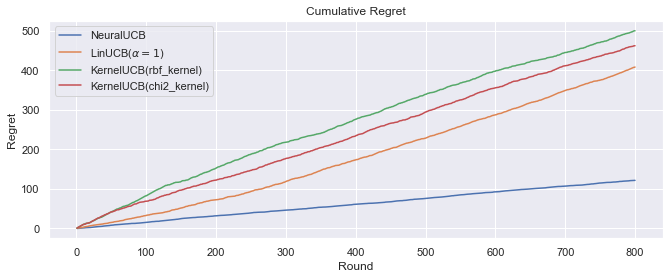

<Figure size 720x288 with 0 Axes>

In [198]:
                                #===============================
                                #    single simulation ...
                                #===============================
num_round = int(800)
#===============================
#    Neural UCB (Contextual) ...
#===============================
result_1 = np.mean(regrets,axis = 0)
print('Accumulative Regret:')
print('- Neural UCB: {}'.format(result_1[-1]))

#===============================
#    Linear UCB (Contextual) ...
#===============================
mab = LinUCB(10, 10, 1.0)
_, _, _,R_2, result_2 = offlineEvaluate(mab, arms, rewards, contexts, num_round)
print('- Linear UCB: {}'.format(R_2))

#===============================
#    Kernel UCB (Contextual) ...
#===============================
mab = KernelUCB(10, 10, 1.0, 1.0, rbf_kernel)
_, _, _, R_3, result_3 = offlineEvaluate(mab, arms, rewards, contexts,num_round)
print('- Kernel UCB(rbf_kernel): {}'.format(R_3))

mab = KernelUCB(10, 10, 1.0, 1.0, chi2_kernel)
_, _, _, R_4, result_4 = offlineEvaluate(mab, arms, rewards, contexts,num_round)
print('- Kernel UCB(chi2_kernel): {}'.format(R_4))

#===============================
#    Plotting results ...
#===============================
fig, ax = plt.subplots(figsize=(11, 4), nrows=1, ncols=1)

plt.figure(figsize=(10,4))
ax.plot((np.linspace(1,num_round,num_round)), result_1, label = r"NeuralUCB")
ax.plot((np.linspace(1,num_round,num_round)), result_2, label = r"LinUCB($\alpha=1$)")
ax.plot((np.linspace(1,num_round,num_round)), result_3, label = r"KernelUCB(rbf_kernel)")
ax.plot((np.linspace(1,num_round,num_round)), result_4, label = r"KernelUCB(chi2_kernel)")

ax.legend()
ax.set_xlabel("Round")
ax.set_ylabel("Regret", fontsize='large')
ax.set_title("Cumulative Regret")

plt.tight_layout()
plt.show()
fig.savefig('figures/MovieLens_regrets_1e4.png')